# Detección de Incendios mediante redes neuronales convolucionales
Integrantes: Nicolas salinas
Fecha de entrega: 8 de diciembre de 2025


# **Introducción**

En Chile, y en el mundo en general, cada año se producen incendios forestales de gran magnitud. Solo en el periodo **2023–2024** en Chile se registraron **71.923 hectáreas afectadas**, cifra significativamente menor que las **428.343 hectáreas** dañadas durante la temporada **2022–2023**, según datos de CONAF.  

Uno de los principales desafíos en la gestión y control de incendios forestales es **detectarlos lo antes posible**. La detección temprana permite una respuesta más rápida, disminuyendo el impacto ambiental, económico y social.  

En este contexto, surge la siguiente problemática central para este trabajo:

**“¿Es posible identificar incendios forestales utilizando imágenes satelitales mediante modelos de redes neuronales convolucionales (CNN)?”**

## **Objetivo General**

- **Entrenar y/o reentrenar un modelo de redes neuronales convolucionales (CNN) capaz de identificar incendios forestales a partir de imágenes satelitales.**



## **Objetivos Específicos**

- Encontrar un dataset público con una cantidad suficiente de imágenes etiquetadas para entrenar un modelo de clasificación.
- Seleccionar un modelo adecuado y compatible con la problemática planteada.
- Entrenar el modelo seleccionado utilizando el dataset encontrado y evaluar su desempeño.


## **Justificación**

La detección temprana de incendios forestales es una tarea crítica y de alto impacto. El uso de modelos basados en inteligencia artificial, especialmente CNN aplicadas a imágenes satelitales, ofrece una alternativa automatizada y escalable para apoyar las labores de monitoreo y respuesta. Esta investigación es relevante porque contribuye al desarrollo de herramientas tecnológicas orientadas a la mitigación de desastres naturales y a la protección de ecosistemas vulnerables.



In [42]:
!pip install torch torchvision datasets transformers matplotlib pandas scikit-learn pillow tqdm  optuna

!pip install --upgrade datasets


!!pip install kagglehub




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 2.3 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 3.2 MB/s eta 0:00:00m eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.6 MB/s eta 0:00:00


['Requirement already satisfied: kagglehub in ./venv/lib/python3.12/site-packages (0.3.13)',
 'Requirement already satisfied: packaging in ./venv/lib/python3.12/site-packages (from kagglehub) (25.0)',
 'Requirement already satisfied: pyyaml in ./venv/lib/python3.12/site-packages (from kagglehub) (6.0.3)',
 'Requirement already satisfied: requests in ./venv/lib/python3.12/site-packages (from kagglehub) (2.32.5)',
 'Requirement already satisfied: tqdm in ./venv/lib/python3.12/site-packages (from kagglehub) (4.67.1)',
 'Requirement already satisfied: charset_normalizer<4,>=2 in ./venv/lib/python3.12/site-packages (from requests->kagglehub) (3.4.3)',
 'Requirement already satisfied: idna<4,>=2.5 in ./venv/lib/python3.12/site-packages (from requests->kagglehub) (3.10)',
 'Requirement already satisfied: urllib3<3,>=1.21.1 in ./venv/lib/python3.12/site-packages (from requests->kagglehub) (2.5.0)',
 'Requirement already satisfied: certifi>=2017.4.17 in ./venv/lib/python3.12/site-packages (from

In [2]:
# ===============================
# Importaciones
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoFeatureExtractor

import datasets

from datasets import load_dataset

import collections


import torchvision.models as models
import torch.nn as nn



from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

device = "cuda" if torch.cuda.is_available() else "cpu"



/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Conjunto de Datos Utilizado**

Para abordar la problemática mencionada previamente, se investigaron diversos conjuntos de datos disponibles públicamente. Inicialmente, se revisaron imágenes satelitales reales proporcionadas por la NASA, las cuales pueden descargarse en tiempo real desde su sitio oficial  
(<https://firms.modaps.eosdis.nasa.gov/download/create.php>).  

Sin embargo, estas imágenes presentaban dos dificultades importantes:

1. **No están clasificadas**, por lo que solo permiten aplicar técnicas de aprendizaje no supervisado.  
2. **Es complejo identificar y filtrar únicamente imágenes correspondientes a incendios forestales**, lo que incrementa significativamente el tiempo de preparación de datos.

Debido a estas limitaciones y al alcance temporal del proyecto, se decidió utilizar un conjunto de datos ya curado y etiquetado: **The Wildfire Dataset**, el cual incluye imágenes clasificadas para entrenar modelos de reconocimiento.  

Este dataset puede descargarse directamente desde Kaggle en el siguiente enlace:  
<https://www.kaggle.com/datasets/elmadafri/the-wildfire-dataset?resource=download>



Ahora pasamos a cargar el data set y mostrar lo que el mismo contiene

In [3]:

DATASET_DIR = r"/home/haru/Escritorio/CNNs_satelites/archive/the_wildfire_dataset_2n_version"


# **Carga del Dataset y Normalización de Datos**

En las siguientes líneas de código se procede a cargar el dataset previamente descrito. Debido a que el conjunto de datos ya viene organizado en las carpetas correspondientes a **train**, **validation** y **test**, no es necesario realizar una división adicional.

Para el preprocesamiento, se aplicó un **redimensionado de todas las imágenes a 224 × 224 píxeles**. Este tamaño se utiliza porque coincide con el formato estándar de entrada de la mayoría de los modelos preentrenados de visión por computadora (como ResNet, EfficientNet, MobileNet, VGG, entre otros). Esto permite evitar incompatibilidades con los pesos preentrenados y asegura que el modelo reciba imágenes en un tamaño uniforme y adecuado para el entrenamiento.


In [4]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.resize((1024, 1024)) if img.size[0] * img.size[1] > 89478485 else img),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])



train_ds = datasets.ImageFolder(os.path.join(DATASET_DIR, "train"), transform=transform)
val_ds   = datasets.ImageFolder(os.path.join(DATASET_DIR, "val"), transform=transform)
test_ds  = datasets.ImageFolder(os.path.join(DATASET_DIR, "test"), transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print ("DATOS CLASE DE ENTRENAMIENTO")
print("=================================")
print("CLASES:", train_ds.classes)
print("Cantidad de imágenes:")
print("Train:", len(train_ds))
print("Val:",   len(val_ds))
print("Test:",  len(test_ds))
print("=================================")
print("DATOS CLASE DE TESTEO")
print("=================================")
print("CLASES:", test_ds.classes)
print("Cantidad de imágenes:")
print("Test:",  len(test_ds))
print("=================================")  
print("DATOS CLASE DE VALIDACION")
print("=================================")
print("CLASES:", val_ds.classes)
print("Cantidad de imágenes:")
print("Val:",  len(val_ds))
print("=================================")



DATOS CLASE DE ENTRENAMIENTO
CLASES: ['fire', 'nofire']
Cantidad de imágenes:
Train: 1887
Val: 402
Test: 410
DATOS CLASE DE TESTEO
CLASES: ['fire', 'nofire']
Cantidad de imágenes:
Test: 410
DATOS CLASE DE VALIDACION
CLASES: ['fire', 'nofire']
Cantidad de imágenes:
Val: 402


Como se puede apreciar, el conjunto de datos ya viene dividido en tres grupos:

- **Train:** 1.887 imágenes  
- **Test:** 410 imágenes  
- **Validación:** 402 imágenes  

En total, el dataset contiene **más de 2.000 imágenes**, las cuales se encuentran clasificadas en dos categorías principales: **imágenes con incendios** e **imágenes sin incendios**. Esta estructura facilita el entrenamiento y la evaluación del modelo, evitando la necesidad de realizar una separación manual y asegurando una distribución adecuada para cada fase del proceso.


Ahora se procedera a mostrar 1as imagenes aleatoras del data set, dichas imagenes estan en la parte de entrenamiento del data set

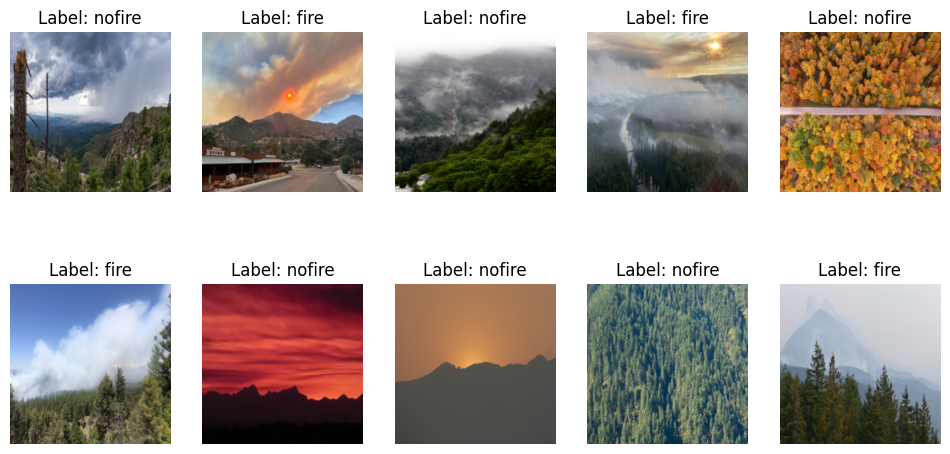

In [5]:
def show_random_images(dataset, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        
        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.title(f"Label: {dataset.classes[label]}")
        plt.axis("off")
    plt.show()


show_random_images(train_ds, n=10)


Como se puede apreciar, las imágenes del conjunto de datos corresponden a bosques con presencia o ausencia de incendios forestales, lo cual resulta ideal para una **clasificación binaria**.  

Además, cada imagen incluye su **etiqueta correspondiente**, ya que el dataset se encuentra organizado de manera supervisada. Por ejemplo, dentro de la carpeta **"train"** existen dos subcarpetas: **"fire"** y **"nofire"**, las cuales contienen imágenes de incendios y de no incendios, respectivamente.  

Esta estructura facilita el uso del dataset para **aprendizaje supervisado**, permitiendo entrenar modelos de clasificación de forma directa sin necesidad de preetiquetar las imágenes.


In [ ]:


train_counts = collections.Counter([label for _, label in train_ds])
val_counts   = collections.Counter([label for _, label in val_ds])
test_counts  = collections.Counter([label for _, label in test_ds])

print("Distribución Train:", train_counts)
print("Distribución Val:", val_counts)
print("Distribución Test:", test_counts)



/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBo

Distribución Train: Counter({1: 1157, 0: 730})
Distribución Val: Counter({1: 246, 0: 156})
Distribución Test: Counter({1: 251, 0: 159})
desbalance train
-427


In [13]:
desbalance_train = train_counts[1] /  train_counts[0]
#desbalance_train1 = (desbalance_train * 1/(train_counts[1] +  train_counts[0])) * 100

print("ratio de desbalance conjunto de entrenamiento")
print(desbalance_train)

desbalance_test = test_counts[1] /  test_counts[0]
#desbalance_test1 = (desbalance_test * 1/(test_counts[1] +  test_counts[0])) * 100

print("ratio de desbalance conjunto de test ")
print(desbalance_test)

desbalance_val = val_counts[1] / val_counts[0]
#desbalance_val1 = (desbalance_val * 1/(val_counts[1] +  val_counts[0])) * 100

print("ratio de desbalance conjunto de validacion ")
print(desbalance_val)



ratio de desbalance conjunto de entrenamiento
1.584931506849315
ratio de desbalance conjunto de test 
1.578616352201258
ratio de desbalance conjunto de validacion 
1.5769230769230769


Aqui se puede apreciar las distribucines de clases de las imagenes , como se puede apreciar si bien existe un ligero desbalance aproximadamemnte en un 60/40, siendo 60 el porcentaje de datos de la clase mayoritaria y 40 el porcentaje de elementos de la clase minoritaria, este no es significativo, por lo cual no se considera necesario realizar un arreglo por ejemplo un undersampling

In [14]:
MODEL_DIR = r"/home/haru/Escritorio/CNNs_satelites/modelos"
os.makedirs(MODEL_DIR, exist_ok=True)

En las siguientes lineas se aprecia las funciones para descargar los modelos

In [15]:


def load_efficientnet(model_name="google/efficientnet-b0", num_labels=2):
    model_folder = os.path.join(MODEL_DIR, model_name.split("/")[-1])
    os.makedirs(model_folder, exist_ok=True)

    print(f"Cargando {model_name} en {model_folder} ...")

    # AutoImageProcessor
    processor = AutoImageProcessor.from_pretrained(model_name, cache_dir=model_folder)
    
    # Cargar modelo preentrenado tal cual (1000 clases)
    model = AutoModelForImageClassification.from_pretrained(
        model_name, cache_dir=model_folder
    )
    
    # Reemplazar la capa final con la cantidad de clases que necesitas
    in_features = model.classifier.in_features
    model.classifier = torch.nn.Linear(in_features, num_labels)

    print(f"{model_name} cargado desde {model_folder}.")
    return model, processor

# Función para descargar y/o cargar un modelo torchvision
def load_torchvision_model(model_name="mobilenet_v3_small", num_labels=2):
    file_path = os.path.join(MODEL_DIR, f"{model_name}.pth")
    
    if os.path.exists(file_path):
        print(f"Cargando {model_name} desde {file_path} ...")
        if model_name == "mobilenet_v3_small":
            model = models.mobilenet_v3_small(pretrained=False)
            model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_labels)
        elif model_name == "resnet50":
            model = models.resnet50(pretrained=False)
            model.fc = nn.Linear(model.fc.in_features, num_labels)
        else:
            raise ValueError("Modelo no soportado")
        model.load_state_dict(torch.load(file_path))
    else:
        print(f"Descargando y guardando {model_name} en {file_path} ...")
        if model_name == "mobilenet_v3_small":
            model = models.mobilenet_v3_small(pretrained=True)
            model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_labels)
        elif model_name == "resnet50":
            model = models.resnet50(pretrained=True)
            model.fc = nn.Linear(model.fc.in_features, num_labels)
        else:
            raise ValueError("Modelo no soportado")
        torch.save(model.state_dict(), file_path)
    
    print(f"{model_name} listo para usar.")
    return model

In [16]:
import matplotlib.pyplot as plt

def plot_model_accuracies(results_dict, title="Comparación de Accuracy"):
    """
    Grafica los accuracies de diferentes modelos.
    
    Args:
        results_dict (dict): Diccionario con {nombre_modelo: accuracy}
        title (str): Título del gráfico
    """
    if not results_dict:
        print("No hay resultados para graficar.")
        return
    
    modelos = list(results_dict.keys())
    accuracies = list(results_dict.values())
    
    plt.figure(figsize=(max(6, len(modelos)*1.5),5))
    bars = plt.bar(modelos, accuracies, color=plt.cm.tab20.colors[:len(modelos)])
    
    plt.ylim(0,1)
    plt.ylabel("Accuracy")
    plt.title(title)
    
    # Agregar valor encima de cada barra
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, acc + 0.01, f"{acc:.2f}", 
                 ha='center', va='bottom', fontweight='bold')
    
    plt.show()


Ahora lo que se hace es cargar 4 modelos distintos, esto con la finalidad de probar los modelos antes de entrenarlos y comprobar que modelo tiene un mejor resultado antes del entrenamiento y elegir el mejor modelo, para lo mismo se generaran amtrices de confusion y graficos mostrando la precision de los modelos

In [17]:
efficientnet_b0, extractor_b0 = load_efficientnet("google/efficientnet-b0")

Cargando google/efficientnet-b0 en /home/haru/Escritorio/CNNs_satelites/modelos/efficientnet-b0 ...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


google/efficientnet-b0 cargado desde /home/haru/Escritorio/CNNs_satelites/modelos/efficientnet-b0.


In [18]:
efficientnet_b5, extractor_b5 = load_efficientnet("google/efficientnet-b5")

Cargando google/efficientnet-b5 en /home/haru/Escritorio/CNNs_satelites/modelos/efficientnet-b5 ...
google/efficientnet-b5 cargado desde /home/haru/Escritorio/CNNs_satelites/modelos/efficientnet-b5.


In [19]:
mobilenet = load_torchvision_model("mobilenet_v3_small")

Cargando mobilenet_v3_small desde /home/haru/Escritorio/CNNs_satelites/modelos/mobilenet_v3_small.pth ...
mobilenet_v3_small listo para usar.


/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
resnet50 = load_torchvision_model("resnet50")

Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.


In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

def evaluate_model(model, dataloader, device="cpu"):
    """
    Evalúa un modelo Hugging Face / PyTorch sobre un DataLoader.
    
    Args:
        model: modelo PyTorch o Hugging Face ya cargado
        dataloader: DataLoader con imágenes y etiquetas
        device: "cpu" o "cuda"
    
    Returns:
        accuracy (float), confusion_matrix (numpy array)
    """
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # Para modelos Hugging Face, los logits están en outputs.logits
            if hasattr(outputs, "logits"):
                outputs = outputs.logits
            
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    return acc, cm


In [23]:
# EfficientNet-B0
acc_b0, cm_b0 = evaluate_model(efficientnet_b0, train_loader, device=device)
print("EfficientNet-B0 - Train Accuracy:", acc_b0)
print("Confusion Matrix:\n", cm_b0)

# MobileNetV3-Small
acc_mn, cm_mn = evaluate_model(mobilenet, train_loader, device=device)
print("MobileNetV3-Small - Train Accuracy:", acc_mn)
print("Confusion Matrix:\n", cm_mn)

# ResNet50
acc_r50, cm_r50 = evaluate_model(resnet50, train_loader, device=device)
print("ResNet50 - Train Accuracy:", acc_r50)
print("Confusion Matrix:\n", cm_r50)

acc_b5,cm_b5 = evaluate_model(efficientnet_b5, train_loader, device = device)
print("EfficientNet-B5- Train Accuracy:", acc_b5)
print("Confusion Matrix:\n", cm_b5)

/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


EfficientNet-B0 - Train Accuracy: 0.4923158452570217
Confusion Matrix:
 [[499 231]
 [727 430]]


/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


MobileNetV3-Small - Train Accuracy: 0.5739268680445151
Confusion Matrix:
 [[  63  667]
 [ 137 1020]]


/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


ResNet50 - Train Accuracy: 0.5786963434022258
Confusion Matrix:
 [[168 562]
 [233 924]]


/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


EfficientNet-B5- Train Accuracy: 0.5574986751457339
Confusion Matrix:
 [[374 356]
 [479 678]]


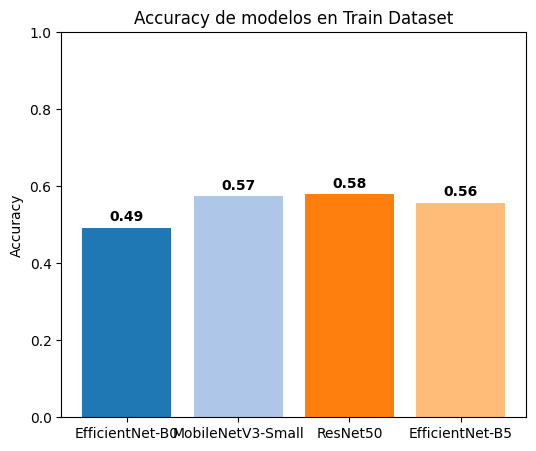

In [24]:
results = {
    "EfficientNet-B0": acc_b0,
    "MobileNetV3-Small": acc_mn,
    "ResNet50": acc_r50,
    "EfficientNet-B5": acc_b5
}

plot_model_accuracies(results, title="Accuracy de modelos en Train Dataset")


In [43]:
del efficientnet_b5
del mobilenet
del efficientnet_b0

COmo se puede apreciar los mejores modelos son "mobileNetV3-small,2 y "ResNet50", se realizaron experimentos entrenando los dos modelos y siempre se obtuvieron mejores resultados con el modelo ResNet 50, por lo mismo en el presente trabajo solo se mostraran los experimentos y resultados del modelo ResNet50

In [44]:
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np


# -----------------------------------------------------------
#     UTILIDAD: Mixup (opcional)
# -----------------------------------------------------------
def mixup_data(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


# -----------------------------------------------------------
#     DESCONGELAR ÚLTIMAS CAPAS
# -----------------------------------------------------------
def unfreeze_last_layers(model, n_last_layers=1, strategy="last_n"):
    for p in model.parameters():
        p.requires_grad = False

    if strategy == "nothing":
        return model

    # Identificar la capa final
    if hasattr(model, "classifier"):
        final_block = model.classifier
    elif hasattr(model, "fc"):
        final_block = model.fc
    else:
        raise ValueError("No se puede identificar la capa final del modelo.")

    if isinstance(final_block, nn.Sequential):
        layers = list(final_block)
    else:
        layers = [final_block]

    if strategy == "all_classifier":
        layers_to_unfreeze = layers
    else:
        layers_to_unfreeze = layers[-n_last_layers:]

    for layer in layers_to_unfreeze:
        for p in layer.parameters():
            p.requires_grad = True

    print(f"se descongelan las ultimas  {len(layers_to_unfreeze)} capas,  con estrategia: {strategy}")
    return model


# -----------------------------------------------------------
#     ENTRENAMIENTO AVANZADO + REPORTE POR ÉPOCA
# -----------------------------------------------------------
def train_cnn(
    model,
    train_loader,
    val_loader,
    num_epochs=5,
    device="cuda",

    # Opciones de fine-tuning
    n_last_layers=2,
    unfreeze_strategy="last_n",

    # Optimización
    lr=1e-3,
    weight_decay=0.0,

    # Regularización
    label_smoothing=0.0,
    mixup_alpha=0.0,
    optimizer_type= "adamw",

    # Early stopping
    early_stopping=True,
    patience=3,
):

    model = unfreeze_last_layers(model, n_last_layers, unfreeze_strategy)
    model.to(device)

    trainable_params = filter(lambda p: p.requires_grad, model.parameters())

    if optimizer_type == "adamw":
        optimizer = AdamW(trainable_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_type == "sgd":
        optimizer = SGD(trainable_params, lr=lr, momentum=0.9, weight_decay=weight_decay)


    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    best_val_acc = 0
    es_counter = 0

    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

    # ENTRENAMIENTO
    for epoch in range(num_epochs):
        model.train()
        total, correct = 0, 0
        running_loss = 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)

            # MIXUP si está activado
            if mixup_alpha > 0:
                imgs, y_a, y_b, lam = mixup_data(imgs, labels, mixup_alpha)

            optimizer.zero_grad()
            outputs = model(imgs)

            if hasattr(outputs, "logits"):
                outputs = outputs.logits

            # loss Mixup o normal
            if mixup_alpha > 0:
                loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)

        # VALIDACIÓN
        model.eval()
        total, correct = 0, 0
        val_loss_accum = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)

                if hasattr(outputs, "logits"):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)
                val_loss_accum += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_loss = val_loss_accum / len(val_loader)

        # Guardar historial
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        # -----------------------------------------------------
        #   REPORTE DETALLADO DE LA ÉPOCA
        # -----------------------------------------------------
        print("\n" + "="*60)
        print(f"Época {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:  {val_acc:.4f}")
        print(f" Mejor Val Acc hasta ahora: {best_val_acc:.4f}")
        print("="*60 + "\n")

        # Early Stopping
        if early_stopping:
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                es_counter = 0
            else:
                es_counter += 1
                if es_counter >= patience:
                    print("Early stopping activado.")
                    break

    print("Entrenamiento finalizado.")
    return model, history


In [45]:
import optuna

def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    n_last_layers = trial.suggest_int("n_last_layers", 1, 4)
    mixup_alpha = trial.suggest_float("mixup_alpha", 0.0, 0.4)
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.2)

 
    optimizer_type = trial.suggest_categorical(
        "optimizer_type", ["adamw", "sgd"]
    )

   
    model = load_torchvision_model("resnet50")  # <-- si necesitas reinicializar, hazlo aquí

    #  ENTRENAR
    model_ft_optuna, hist = train_cnn(
        model,
        train_loader, val_loader,
        num_epochs=8,                 # menor para pruebas rápidas
        n_last_layers=n_last_layers,
        unfreeze_strategy="last_n",
        lr=lr,
        weight_decay=weight_decay,
        mixup_alpha=mixup_alpha,
        label_smoothing=label_smoothing,
        optimizer_type=optimizer_type,
        early_stopping=True,
        patience=2
    )

    #  devolver la métrica a optimizar (VALIDACIÓN)
    val_acc = hist["val_acc"][-1]
    return val_acc


In [46]:
study = optuna.create_study(
    direction="maximize",
    study_name="resnet50_hparam_search"
)

study.optimize(objective, n_trials=20)  # puedes subir a 50–100


[I 2025-11-25 07:14:33,844] A new study created in memory with name: resnet50_hparam_search
/tmp/ipykernel_4367/359750843.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_4367/359750843.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/torc

Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8:  34%|███▍      | 20/59 [01:25<02:36,  4.00s/it]/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 1/8:  68%|██████▊   | 40/59 [02:54<01:22,  4.33s/it]/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 1/8: 100%|██████████| 59/59 [04:23<00:00,  4.46s/it]



Época 1/8
Train Loss: 0.6523 | Train Acc: 0.6089
Val Loss:   0.6082 | Val Acc:  0.7214
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:23<00:00,  4.47s/it]



Época 2/8
Train Loss: 0.6088 | Train Acc: 0.6433
Val Loss:   0.5555 | Val Acc:  0.7488
 Mejor Val Acc hasta ahora: 0.7214



Epoch 3/8: 100%|██████████| 59/59 [04:16<00:00,  4.34s/it]



Época 3/8
Train Loss: 0.5732 | Train Acc: 0.6741
Val Loss:   0.5267 | Val Acc:  0.7711
 Mejor Val Acc hasta ahora: 0.7488



Epoch 4/8: 100%|██████████| 59/59 [04:17<00:00,  4.36s/it]



Época 4/8
Train Loss: 0.5459 | Train Acc: 0.6619
Val Loss:   0.5006 | Val Acc:  0.8060
 Mejor Val Acc hasta ahora: 0.7711



Epoch 5/8: 100%|██████████| 59/59 [04:17<00:00,  4.36s/it]



Época 5/8
Train Loss: 0.5322 | Train Acc: 0.7069
Val Loss:   0.4768 | Val Acc:  0.8159
 Mejor Val Acc hasta ahora: 0.8060



Epoch 6/8: 100%|██████████| 59/59 [04:19<00:00,  4.41s/it]



Época 6/8
Train Loss: 0.5157 | Train Acc: 0.6990
Val Loss:   0.4621 | Val Acc:  0.8308
 Mejor Val Acc hasta ahora: 0.8159



Epoch 7/8: 100%|██████████| 59/59 [04:20<00:00,  4.42s/it]



Época 7/8
Train Loss: 0.5090 | Train Acc: 0.6995
Val Loss:   0.4500 | Val Acc:  0.8383
 Mejor Val Acc hasta ahora: 0.8308



Epoch 8/8: 100%|██████████| 59/59 [04:17<00:00,  4.36s/it]
[I 2025-11-25 07:56:29,235] Trial 0 finished with value: 0.8383084577114428 and parameters: {'lr': 5.437131086677999e-05, 'weight_decay': 0.00017562208181593503, 'n_last_layers': 1, 'mixup_alpha': 0.36564844844186783, 'label_smoothing': 0.014870552081855483, 'optimizer_type': 'adamw'}. Best is trial 0 with value: 0.8383084577114428.



Época 8/8
Train Loss: 0.4943 | Train Acc: 0.7001
Val Loss:   0.4421 | Val Acc:  0.8383
 Mejor Val Acc hasta ahora: 0.8383

Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:25<00:00,  4.50s/it]



Época 1/8
Train Loss: 0.6795 | Train Acc: 0.5808
Val Loss:   0.6623 | Val Acc:  0.6020
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:31<00:00,  4.59s/it]



Época 2/8
Train Loss: 0.6702 | Train Acc: 0.5983
Val Loss:   0.6539 | Val Acc:  0.6468
 Mejor Val Acc hasta ahora: 0.6020



Epoch 3/8: 100%|██████████| 59/59 [04:30<00:00,  4.58s/it]



Época 3/8
Train Loss: 0.6665 | Train Acc: 0.6179
Val Loss:   0.6478 | Val Acc:  0.6393
 Mejor Val Acc hasta ahora: 0.6468



Epoch 4/8: 100%|██████████| 59/59 [04:29<00:00,  4.56s/it]



Época 4/8
Train Loss: 0.6558 | Train Acc: 0.6237
Val Loss:   0.6408 | Val Acc:  0.6542
 Mejor Val Acc hasta ahora: 0.6468



Epoch 5/8: 100%|██████████| 59/59 [04:31<00:00,  4.59s/it]



Época 5/8
Train Loss: 0.6513 | Train Acc: 0.6153
Val Loss:   0.6322 | Val Acc:  0.6667
 Mejor Val Acc hasta ahora: 0.6542



Epoch 6/8: 100%|██████████| 59/59 [04:32<00:00,  4.62s/it]



Época 6/8
Train Loss: 0.6442 | Train Acc: 0.6163
Val Loss:   0.6264 | Val Acc:  0.6592
 Mejor Val Acc hasta ahora: 0.6667



Epoch 7/8: 100%|██████████| 59/59 [04:29<00:00,  4.56s/it]



Época 7/8
Train Loss: 0.6418 | Train Acc: 0.6317
Val Loss:   0.6203 | Val Acc:  0.6692
 Mejor Val Acc hasta ahora: 0.6667



Epoch 8/8: 100%|██████████| 59/59 [04:27<00:00,  4.53s/it]
[I 2025-11-25 08:39:58,807] Trial 1 finished with value: 0.7014925373134329 and parameters: {'lr': 1.252994059493885e-05, 'weight_decay': 1.8715365521079952e-06, 'n_last_layers': 3, 'mixup_alpha': 0.2897403151260498, 'label_smoothing': 0.12037791489467309, 'optimizer_type': 'sgd'}. Best is trial 0 with value: 0.8383084577114428.



Época 8/8
Train Loss: 0.6344 | Train Acc: 0.6333
Val Loss:   0.6146 | Val Acc:  0.7015
 Mejor Val Acc hasta ahora: 0.6692

Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:34<00:00,  4.65s/it]



Época 1/8
Train Loss: 0.6141 | Train Acc: 0.6449
Val Loss:   0.5223 | Val Acc:  0.8010
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:31<00:00,  4.61s/it]



Época 2/8
Train Loss: 0.5085 | Train Acc: 0.6963
Val Loss:   0.4580 | Val Acc:  0.8333
 Mejor Val Acc hasta ahora: 0.8010



Epoch 3/8: 100%|██████████| 59/59 [04:31<00:00,  4.59s/it]



Época 3/8
Train Loss: 0.4574 | Train Acc: 0.6974
Val Loss:   0.4235 | Val Acc:  0.8458
 Mejor Val Acc hasta ahora: 0.8333



Epoch 4/8: 100%|██████████| 59/59 [04:30<00:00,  4.59s/it]



Época 4/8
Train Loss: 0.4447 | Train Acc: 0.7149
Val Loss:   0.4126 | Val Acc:  0.8308
 Mejor Val Acc hasta ahora: 0.8458



Epoch 5/8: 100%|██████████| 59/59 [04:31<00:00,  4.60s/it]
[I 2025-11-25 09:07:21,833] Trial 2 finished with value: 0.845771144278607 and parameters: {'lr': 0.00017676946052791606, 'weight_decay': 1.8495909775848954e-05, 'n_last_layers': 2, 'mixup_alpha': 0.1405772626511256, 'label_smoothing': 0.03506304187213329, 'optimizer_type': 'adamw'}. Best is trial 2 with value: 0.845771144278607.



Época 5/8
Train Loss: 0.4200 | Train Acc: 0.7430
Val Loss:   0.3954 | Val Acc:  0.8458
 Mejor Val Acc hasta ahora: 0.8458

Early stopping activado.
Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:35<00:00,  4.67s/it]



Época 1/8
Train Loss: 0.6350 | Train Acc: 0.6328
Val Loss:   0.5624 | Val Acc:  0.8010
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:33<00:00,  4.64s/it]



Época 2/8
Train Loss: 0.5872 | Train Acc: 0.6789
Val Loss:   0.5285 | Val Acc:  0.8284
 Mejor Val Acc hasta ahora: 0.8010



Epoch 3/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]



Época 3/8
Train Loss: 0.5594 | Train Acc: 0.6762
Val Loss:   0.5150 | Val Acc:  0.8159
 Mejor Val Acc hasta ahora: 0.8284



Epoch 4/8: 100%|██████████| 59/59 [04:35<00:00,  4.67s/it]



Época 4/8
Train Loss: 0.5469 | Train Acc: 0.6921
Val Loss:   0.5102 | Val Acc:  0.8383
 Mejor Val Acc hasta ahora: 0.8284



Epoch 5/8: 100%|██████████| 59/59 [04:34<00:00,  4.66s/it]



Época 5/8
Train Loss: 0.5392 | Train Acc: 0.6948
Val Loss:   0.4945 | Val Acc:  0.8507
 Mejor Val Acc hasta ahora: 0.8383



Epoch 6/8: 100%|██████████| 59/59 [04:35<00:00,  4.66s/it]



Época 6/8
Train Loss: 0.5356 | Train Acc: 0.7101
Val Loss:   0.4982 | Val Acc:  0.8259
 Mejor Val Acc hasta ahora: 0.8507



Epoch 7/8: 100%|██████████| 59/59 [04:37<00:00,  4.71s/it]
[I 2025-11-25 09:46:17,395] Trial 3 finished with value: 0.8482587064676617 and parameters: {'lr': 0.00018492915109155132, 'weight_decay': 0.0003380489018686028, 'n_last_layers': 1, 'mixup_alpha': 0.32857329436644944, 'label_smoothing': 0.19265049292815203, 'optimizer_type': 'adamw'}. Best is trial 3 with value: 0.8482587064676617.



Época 7/8
Train Loss: 0.5205 | Train Acc: 0.6942
Val Loss:   0.4882 | Val Acc:  0.8483
 Mejor Val Acc hasta ahora: 0.8507

Early stopping activado.
Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:36<00:00,  4.69s/it]



Época 1/8
Train Loss: 0.5916 | Train Acc: 0.6370
Val Loss:   0.5134 | Val Acc:  0.8308
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:40<00:00,  4.76s/it]



Época 2/8
Train Loss: 0.5038 | Train Acc: 0.6942
Val Loss:   0.4524 | Val Acc:  0.8358
 Mejor Val Acc hasta ahora: 0.8308



Epoch 3/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]



Época 3/8
Train Loss: 0.4867 | Train Acc: 0.6958
Val Loss:   0.4349 | Val Acc:  0.8433
 Mejor Val Acc hasta ahora: 0.8358



Epoch 4/8: 100%|██████████| 59/59 [04:36<00:00,  4.69s/it]



Época 4/8
Train Loss: 0.4681 | Train Acc: 0.7043
Val Loss:   0.4248 | Val Acc:  0.8383
 Mejor Val Acc hasta ahora: 0.8433



Epoch 5/8: 100%|██████████| 59/59 [04:44<00:00,  4.83s/it]



Época 5/8
Train Loss: 0.4667 | Train Acc: 0.7181
Val Loss:   0.4149 | Val Acc:  0.8458
 Mejor Val Acc hasta ahora: 0.8433



Epoch 6/8: 100%|██████████| 59/59 [8:51:47<00:00, 540.81s/it]    



Época 6/8
Train Loss: 0.4415 | Train Acc: 0.6921
Val Loss:   0.4101 | Val Acc:  0.8433
 Mejor Val Acc hasta ahora: 0.8458



Epoch 7/8: 100%|██████████| 59/59 [04:41<00:00,  4.77s/it]



Época 7/8
Train Loss: 0.4335 | Train Acc: 0.7096
Val Loss:   0.4030 | Val Acc:  0.8557
 Mejor Val Acc hasta ahora: 0.8458



Epoch 8/8: 100%|██████████| 59/59 [04:42<00:00,  4.78s/it]
[I 2025-11-25 19:18:26,366] Trial 4 finished with value: 0.8407960199004975 and parameters: {'lr': 0.0003088851231329876, 'weight_decay': 0.0004858982642665716, 'n_last_layers': 4, 'mixup_alpha': 0.18893018987750945, 'label_smoothing': 0.08298435609610902, 'optimizer_type': 'adamw'}. Best is trial 3 with value: 0.8482587064676617.



Época 8/8
Train Loss: 0.4247 | Train Acc: 0.7451
Val Loss:   0.4085 | Val Acc:  0.8408
 Mejor Val Acc hasta ahora: 0.8557

Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]



Época 1/8
Train Loss: 0.5977 | Train Acc: 0.6338
Val Loss:   0.4559 | Val Acc:  0.8209
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]



Época 2/8
Train Loss: 0.4770 | Train Acc: 0.7069
Val Loss:   0.4176 | Val Acc:  0.8557
 Mejor Val Acc hasta ahora: 0.8209



Epoch 3/8: 100%|██████████| 59/59 [04:39<00:00,  4.74s/it]



Época 3/8
Train Loss: 0.4476 | Train Acc: 0.7101
Val Loss:   0.4047 | Val Acc:  0.8433
 Mejor Val Acc hasta ahora: 0.8557



Epoch 4/8: 100%|██████████| 59/59 [04:37<00:00,  4.71s/it]
[I 2025-11-25 19:40:51,589] Trial 5 finished with value: 0.7885572139303483 and parameters: {'lr': 0.0007374882284187339, 'weight_decay': 2.7330035261614227e-06, 'n_last_layers': 4, 'mixup_alpha': 0.2082458287114366, 'label_smoothing': 0.07243731165119753, 'optimizer_type': 'adamw'}. Best is trial 3 with value: 0.8482587064676617.



Época 4/8
Train Loss: 0.4592 | Train Acc: 0.6953
Val Loss:   0.4833 | Val Acc:  0.7886
 Mejor Val Acc hasta ahora: 0.8557

Early stopping activado.
Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]



Época 1/8
Train Loss: 0.5816 | Train Acc: 0.6677
Val Loss:   0.4580 | Val Acc:  0.8234
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:40<00:00,  4.76s/it]



Época 2/8
Train Loss: 0.4841 | Train Acc: 0.7218
Val Loss:   0.3989 | Val Acc:  0.8483
 Mejor Val Acc hasta ahora: 0.8234



Epoch 3/8: 100%|██████████| 59/59 [04:38<00:00,  4.71s/it]



Época 3/8
Train Loss: 0.4772 | Train Acc: 0.6905
Val Loss:   0.3773 | Val Acc:  0.8433
 Mejor Val Acc hasta ahora: 0.8483



Epoch 4/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]
[I 2025-11-25 20:03:18,243] Trial 6 finished with value: 0.8308457711442786 and parameters: {'lr': 0.000415823890929391, 'weight_decay': 4.362580763160503e-05, 'n_last_layers': 3, 'mixup_alpha': 0.37440839755795063, 'label_smoothing': 0.0013822117602731998, 'optimizer_type': 'adamw'}. Best is trial 3 with value: 0.8482587064676617.



Época 4/8
Train Loss: 0.4501 | Train Acc: 0.6873
Val Loss:   0.3619 | Val Acc:  0.8308
 Mejor Val Acc hasta ahora: 0.8483

Early stopping activado.
Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:30<00:00,  4.59s/it]



Época 1/8
Train Loss: 0.6757 | Train Acc: 0.5866
Val Loss:   0.6591 | Val Acc:  0.5995
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:31<00:00,  4.60s/it]



Época 2/8
Train Loss: 0.6597 | Train Acc: 0.6105
Val Loss:   0.6452 | Val Acc:  0.6443
 Mejor Val Acc hasta ahora: 0.5995



Epoch 3/8: 100%|██████████| 59/59 [04:31<00:00,  4.61s/it]



Época 3/8
Train Loss: 0.6438 | Train Acc: 0.6253
Val Loss:   0.6293 | Val Acc:  0.6667
 Mejor Val Acc hasta ahora: 0.6443



Epoch 4/8: 100%|██████████| 59/59 [04:32<00:00,  4.61s/it]



Época 4/8
Train Loss: 0.6263 | Train Acc: 0.6227
Val Loss:   0.6169 | Val Acc:  0.6940
 Mejor Val Acc hasta ahora: 0.6667



Epoch 5/8: 100%|██████████| 59/59 [04:30<00:00,  4.59s/it]



Época 5/8
Train Loss: 0.6162 | Train Acc: 0.6449
Val Loss:   0.6068 | Val Acc:  0.7189
 Mejor Val Acc hasta ahora: 0.6940



Epoch 6/8: 100%|██████████| 59/59 [04:27<00:00,  4.54s/it]



Época 6/8
Train Loss: 0.6031 | Train Acc: 0.6508
Val Loss:   0.5954 | Val Acc:  0.7289
 Mejor Val Acc hasta ahora: 0.7189



Epoch 7/8: 100%|██████████| 59/59 [04:29<00:00,  4.57s/it]



Época 7/8
Train Loss: 0.5926 | Train Acc: 0.6486
Val Loss:   0.5859 | Val Acc:  0.7612
 Mejor Val Acc hasta ahora: 0.7289



Epoch 8/8: 100%|██████████| 59/59 [04:30<00:00,  4.59s/it]
[I 2025-11-25 20:46:58,428] Trial 7 finished with value: 0.7686567164179104 and parameters: {'lr': 1.3553738005280408e-05, 'weight_decay': 3.9843318406956344e-05, 'n_last_layers': 3, 'mixup_alpha': 0.005679496457068645, 'label_smoothing': 0.17452077105628064, 'optimizer_type': 'adamw'}. Best is trial 3 with value: 0.8482587064676617.



Época 8/8
Train Loss: 0.5842 | Train Acc: 0.6248
Val Loss:   0.5788 | Val Acc:  0.7687
 Mejor Val Acc hasta ahora: 0.7612

Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:35<00:00,  4.67s/it]



Época 1/8
Train Loss: 0.6734 | Train Acc: 0.5803
Val Loss:   0.6471 | Val Acc:  0.6194
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:35<00:00,  4.66s/it]



Época 2/8
Train Loss: 0.6580 | Train Acc: 0.6142
Val Loss:   0.6255 | Val Acc:  0.6418
 Mejor Val Acc hasta ahora: 0.6194



Epoch 3/8: 100%|██████████| 59/59 [04:40<00:00,  4.75s/it]



Época 3/8
Train Loss: 0.6460 | Train Acc: 0.6206
Val Loss:   0.6143 | Val Acc:  0.6493
 Mejor Val Acc hasta ahora: 0.6418



Epoch 4/8: 100%|██████████| 59/59 [04:39<00:00,  4.74s/it]



Época 4/8
Train Loss: 0.6338 | Train Acc: 0.6243
Val Loss:   0.6004 | Val Acc:  0.6866
 Mejor Val Acc hasta ahora: 0.6493



Epoch 5/8: 100%|██████████| 59/59 [04:36<00:00,  4.68s/it]



Época 5/8
Train Loss: 0.6194 | Train Acc: 0.6396
Val Loss:   0.5913 | Val Acc:  0.6940
 Mejor Val Acc hasta ahora: 0.6866



Epoch 6/8: 100%|██████████| 59/59 [04:36<00:00,  4.69s/it]



Época 6/8
Train Loss: 0.6061 | Train Acc: 0.6402
Val Loss:   0.5772 | Val Acc:  0.7090
 Mejor Val Acc hasta ahora: 0.6940



Epoch 7/8: 100%|██████████| 59/59 [04:36<00:00,  4.68s/it]



Época 7/8
Train Loss: 0.5965 | Train Acc: 0.6704
Val Loss:   0.5665 | Val Acc:  0.7313
 Mejor Val Acc hasta ahora: 0.7090



Epoch 8/8: 100%|██████████| 59/59 [04:38<00:00,  4.73s/it]
[I 2025-11-25 21:31:37,218] Trial 8 finished with value: 0.736318407960199 and parameters: {'lr': 2.14878160508122e-05, 'weight_decay': 8.424838196907372e-05, 'n_last_layers': 3, 'mixup_alpha': 0.383905692042395, 'label_smoothing': 0.003053254434597164, 'optimizer_type': 'sgd'}. Best is trial 3 with value: 0.8482587064676617.



Época 8/8
Train Loss: 0.5915 | Train Acc: 0.6698
Val Loss:   0.5561 | Val Acc:  0.7363
 Mejor Val Acc hasta ahora: 0.7313

Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:35<00:00,  4.67s/it]



Época 1/8
Train Loss: 0.6748 | Train Acc: 0.5877
Val Loss:   0.6522 | Val Acc:  0.6169
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:40<00:00,  4.75s/it]



Época 2/8
Train Loss: 0.6605 | Train Acc: 0.6094
Val Loss:   0.6414 | Val Acc:  0.6393
 Mejor Val Acc hasta ahora: 0.6169



Epoch 3/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]



Época 3/8
Train Loss: 0.6509 | Train Acc: 0.6200
Val Loss:   0.6265 | Val Acc:  0.6592
 Mejor Val Acc hasta ahora: 0.6393



Epoch 4/8: 100%|██████████| 59/59 [04:39<00:00,  4.73s/it]



Época 4/8
Train Loss: 0.6398 | Train Acc: 0.6285
Val Loss:   0.6183 | Val Acc:  0.6692
 Mejor Val Acc hasta ahora: 0.6592



Epoch 5/8: 100%|██████████| 59/59 [04:40<00:00,  4.76s/it]



Época 5/8
Train Loss: 0.6284 | Train Acc: 0.6253
Val Loss:   0.6055 | Val Acc:  0.6791
 Mejor Val Acc hasta ahora: 0.6692



Epoch 6/8: 100%|██████████| 59/59 [04:41<00:00,  4.77s/it]



Época 6/8
Train Loss: 0.6267 | Train Acc: 0.6380
Val Loss:   0.5944 | Val Acc:  0.6940
 Mejor Val Acc hasta ahora: 0.6791



Epoch 7/8: 100%|██████████| 59/59 [04:41<00:00,  4.78s/it]



Época 7/8
Train Loss: 0.6125 | Train Acc: 0.6460
Val Loss:   0.5874 | Val Acc:  0.6965
 Mejor Val Acc hasta ahora: 0.6940



Epoch 8/8: 100%|██████████| 59/59 [04:42<00:00,  4.80s/it]
[I 2025-11-25 22:16:39,845] Trial 9 finished with value: 0.7139303482587065 and parameters: {'lr': 1.787236212740099e-05, 'weight_decay': 7.358162770915023e-05, 'n_last_layers': 4, 'mixup_alpha': 0.3031986248384455, 'label_smoothing': 0.043660225460361926, 'optimizer_type': 'sgd'}. Best is trial 3 with value: 0.8482587064676617.



Época 8/8
Train Loss: 0.6054 | Train Acc: 0.6449
Val Loss:   0.5828 | Val Acc:  0.7139
 Mejor Val Acc hasta ahora: 0.6965

Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:44<00:00,  4.82s/it]



Época 1/8
Train Loss: 0.6698 | Train Acc: 0.5909
Val Loss:   0.6411 | Val Acc:  0.6468
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:42<00:00,  4.79s/it]



Época 2/8
Train Loss: 0.6355 | Train Acc: 0.6359
Val Loss:   0.6146 | Val Acc:  0.7189
 Mejor Val Acc hasta ahora: 0.6468



Epoch 3/8: 100%|██████████| 59/59 [04:42<00:00,  4.79s/it]



Época 3/8
Train Loss: 0.6108 | Train Acc: 0.6354
Val Loss:   0.5939 | Val Acc:  0.7363
 Mejor Val Acc hasta ahora: 0.7189



Epoch 4/8: 100%|██████████| 59/59 [04:40<00:00,  4.75s/it]



Época 4/8
Train Loss: 0.5950 | Train Acc: 0.6847
Val Loss:   0.5740 | Val Acc:  0.7836
 Mejor Val Acc hasta ahora: 0.7363



Epoch 5/8: 100%|██████████| 59/59 [04:40<00:00,  4.75s/it]



Época 5/8
Train Loss: 0.5757 | Train Acc: 0.7186
Val Loss:   0.5629 | Val Acc:  0.8010
 Mejor Val Acc hasta ahora: 0.7836



Epoch 6/8: 100%|██████████| 59/59 [04:37<00:00,  4.71s/it]



Época 6/8
Train Loss: 0.5709 | Train Acc: 0.6895
Val Loss:   0.5539 | Val Acc:  0.8035
 Mejor Val Acc hasta ahora: 0.8010



Epoch 7/8: 100%|██████████| 59/59 [04:42<00:00,  4.79s/it]



Época 7/8
Train Loss: 0.5602 | Train Acc: 0.7016
Val Loss:   0.5478 | Val Acc:  0.7985
 Mejor Val Acc hasta ahora: 0.8035



Epoch 8/8: 100%|██████████| 59/59 [04:43<00:00,  4.81s/it]
[I 2025-11-25 23:02:01,199] Trial 10 finished with value: 0.8159203980099502 and parameters: {'lr': 6.733134532056013e-05, 'weight_decay': 0.0008681717643083769, 'n_last_layers': 1, 'mixup_alpha': 0.07191939338701445, 'label_smoothing': 0.19955194828590317, 'optimizer_type': 'sgd'}. Best is trial 3 with value: 0.8482587064676617.



Época 8/8
Train Loss: 0.5474 | Train Acc: 0.7032
Val Loss:   0.5392 | Val Acc:  0.8159
 Mejor Val Acc hasta ahora: 0.8035

Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:39<00:00,  4.73s/it]



Época 1/8
Train Loss: 0.6121 | Train Acc: 0.6200
Val Loss:   0.5326 | Val Acc:  0.7960
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:43<00:00,  4.80s/it]



Época 2/8
Train Loss: 0.5245 | Train Acc: 0.6672
Val Loss:   0.4903 | Val Acc:  0.8408
 Mejor Val Acc hasta ahora: 0.7960



Epoch 3/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]



Época 3/8
Train Loss: 0.5096 | Train Acc: 0.7080
Val Loss:   0.4695 | Val Acc:  0.8507
 Mejor Val Acc hasta ahora: 0.8408



Epoch 4/8: 100%|██████████| 59/59 [04:40<00:00,  4.76s/it]



Época 4/8
Train Loss: 0.4795 | Train Acc: 0.7011
Val Loss:   0.4609 | Val Acc:  0.8483
 Mejor Val Acc hasta ahora: 0.8507



Epoch 5/8: 100%|██████████| 59/59 [04:39<00:00,  4.74s/it]
[I 2025-11-25 23:30:11,750] Trial 11 finished with value: 0.8407960199004975 and parameters: {'lr': 0.00022076213571206176, 'weight_decay': 8.309295102969977e-06, 'n_last_layers': 2, 'mixup_alpha': 0.15051939334250725, 'label_smoothing': 0.13246451005890836, 'optimizer_type': 'adamw'}. Best is trial 3 with value: 0.8482587064676617.



Época 5/8
Train Loss: 0.4615 | Train Acc: 0.7064
Val Loss:   0.4606 | Val Acc:  0.8408
 Mejor Val Acc hasta ahora: 0.8507

Early stopping activado.
Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:42<00:00,  4.79s/it]



Época 1/8
Train Loss: 0.6319 | Train Acc: 0.6280
Val Loss:   0.5761 | Val Acc:  0.7040
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:42<00:00,  4.79s/it]



Época 2/8
Train Loss: 0.5534 | Train Acc: 0.6624
Val Loss:   0.5171 | Val Acc:  0.8284
 Mejor Val Acc hasta ahora: 0.7040



Epoch 3/8: 100%|██████████| 59/59 [04:39<00:00,  4.74s/it]



Época 3/8
Train Loss: 0.5130 | Train Acc: 0.6873
Val Loss:   0.4947 | Val Acc:  0.8433
 Mejor Val Acc hasta ahora: 0.8284



Epoch 4/8: 100%|██████████| 59/59 [04:39<00:00,  4.73s/it]



Época 4/8
Train Loss: 0.5012 | Train Acc: 0.6831
Val Loss:   0.4820 | Val Acc:  0.8483
 Mejor Val Acc hasta ahora: 0.8433



Epoch 5/8: 100%|██████████| 59/59 [04:41<00:00,  4.77s/it]



Época 5/8
Train Loss: 0.4962 | Train Acc: 0.7054
Val Loss:   0.4731 | Val Acc:  0.8483
 Mejor Val Acc hasta ahora: 0.8483



Epoch 6/8: 100%|██████████| 59/59 [04:48<00:00,  4.88s/it]
[I 2025-11-26 00:04:14,240] Trial 12 finished with value: 0.8432835820895522 and parameters: {'lr': 0.0001354214385653224, 'weight_decay': 1.0447007735075631e-05, 'n_last_layers': 2, 'mixup_alpha': 0.12414744747960585, 'label_smoothing': 0.14493029583954872, 'optimizer_type': 'adamw'}. Best is trial 3 with value: 0.8482587064676617.



Época 6/8
Train Loss: 0.4873 | Train Acc: 0.6932
Val Loss:   0.4731 | Val Acc:  0.8433
 Mejor Val Acc hasta ahora: 0.8483

Early stopping activado.
Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]



Época 1/8
Train Loss: 0.6271 | Train Acc: 0.6444
Val Loss:   0.5645 | Val Acc:  0.6642
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:36<00:00,  4.69s/it]



Época 2/8
Train Loss: 0.5496 | Train Acc: 0.6396
Val Loss:   0.5061 | Val Acc:  0.7587
 Mejor Val Acc hasta ahora: 0.6642



Epoch 3/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]



Época 3/8
Train Loss: 0.5119 | Train Acc: 0.6783
Val Loss:   0.4678 | Val Acc:  0.8308
 Mejor Val Acc hasta ahora: 0.7587



Epoch 4/8: 100%|██████████| 59/59 [04:36<00:00,  4.69s/it]



Época 4/8
Train Loss: 0.5029 | Train Acc: 0.6990
Val Loss:   0.4497 | Val Acc:  0.8184
 Mejor Val Acc hasta ahora: 0.8308



Epoch 5/8: 100%|██████████| 59/59 [04:34<00:00,  4.65s/it]



Época 5/8
Train Loss: 0.4648 | Train Acc: 0.7112
Val Loss:   0.4361 | Val Acc:  0.8333
 Mejor Val Acc hasta ahora: 0.8308



Epoch 6/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]



Época 6/8
Train Loss: 0.4670 | Train Acc: 0.6884
Val Loss:   0.4215 | Val Acc:  0.8433
 Mejor Val Acc hasta ahora: 0.8333



Epoch 7/8: 100%|██████████| 59/59 [04:35<00:00,  4.67s/it]



Época 7/8
Train Loss: 0.4658 | Train Acc: 0.6953
Val Loss:   0.4161 | Val Acc:  0.8408
 Mejor Val Acc hasta ahora: 0.8433



Epoch 8/8: 100%|██████████| 59/59 [04:32<00:00,  4.62s/it]
[I 2025-11-26 00:48:48,532] Trial 13 finished with value: 0.8482587064676617 and parameters: {'lr': 0.0001275612984576673, 'weight_decay': 1.3476801429750091e-05, 'n_last_layers': 1, 'mixup_alpha': 0.2539648407831297, 'label_smoothing': 0.053081384965378633, 'optimizer_type': 'adamw'}. Best is trial 3 with value: 0.8482587064676617.



Época 8/8
Train Loss: 0.4745 | Train Acc: 0.6545
Val Loss:   0.4132 | Val Acc:  0.8483
 Mejor Val Acc hasta ahora: 0.8433

Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:37<00:00,  4.71s/it]



Época 1/8
Train Loss: 0.6515 | Train Acc: 0.6116
Val Loss:   0.6034 | Val Acc:  0.7488
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:40<00:00,  4.75s/it]



Época 2/8
Train Loss: 0.6011 | Train Acc: 0.6486
Val Loss:   0.5493 | Val Acc:  0.7537
 Mejor Val Acc hasta ahora: 0.7488



Epoch 3/8: 100%|██████████| 59/59 [04:39<00:00,  4.75s/it]



Época 3/8
Train Loss: 0.5612 | Train Acc: 0.6736
Val Loss:   0.5220 | Val Acc:  0.8035
 Mejor Val Acc hasta ahora: 0.7537



Epoch 4/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]



Época 4/8
Train Loss: 0.5457 | Train Acc: 0.6635
Val Loss:   0.4937 | Val Acc:  0.8159
 Mejor Val Acc hasta ahora: 0.8035



Epoch 5/8: 100%|██████████| 59/59 [04:40<00:00,  4.76s/it]



Época 5/8
Train Loss: 0.5206 | Train Acc: 0.7101
Val Loss:   0.4749 | Val Acc:  0.8209
 Mejor Val Acc hasta ahora: 0.8159



Epoch 6/8: 100%|██████████| 59/59 [04:40<00:00,  4.75s/it]



Época 6/8
Train Loss: 0.5141 | Train Acc: 0.6958
Val Loss:   0.4670 | Val Acc:  0.8159
 Mejor Val Acc hasta ahora: 0.8209



Epoch 7/8: 100%|██████████| 59/59 [04:34<00:00,  4.65s/it]



Época 7/8
Train Loss: 0.4991 | Train Acc: 0.6889
Val Loss:   0.4528 | Val Acc:  0.8458
 Mejor Val Acc hasta ahora: 0.8209



Epoch 8/8: 100%|██████████| 59/59 [04:39<00:00,  4.73s/it]
[I 2025-11-26 01:33:40,166] Trial 14 finished with value: 0.8407960199004975 and parameters: {'lr': 6.690656107980149e-05, 'weight_decay': 0.0002540560487489108, 'n_last_layers': 1, 'mixup_alpha': 0.27654229894149923, 'label_smoothing': 0.06289585653346927, 'optimizer_type': 'adamw'}. Best is trial 3 with value: 0.8482587064676617.



Época 8/8
Train Loss: 0.4830 | Train Acc: 0.7292
Val Loss:   0.4492 | Val Acc:  0.8408
 Mejor Val Acc hasta ahora: 0.8458

Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:49<00:00,  4.91s/it]



Época 1/8
Train Loss: 0.6609 | Train Acc: 0.6094
Val Loss:   0.6260 | Val Acc:  0.6592
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:49<00:00,  4.91s/it]



Época 2/8
Train Loss: 0.6290 | Train Acc: 0.6513
Val Loss:   0.5959 | Val Acc:  0.7438
 Mejor Val Acc hasta ahora: 0.6592



Epoch 3/8: 100%|██████████| 59/59 [04:46<00:00,  4.86s/it]



Época 3/8
Train Loss: 0.6042 | Train Acc: 0.6444
Val Loss:   0.5723 | Val Acc:  0.7562
 Mejor Val Acc hasta ahora: 0.7438



Epoch 4/8: 100%|██████████| 59/59 [04:50<00:00,  4.92s/it]



Época 4/8
Train Loss: 0.5799 | Train Acc: 0.6630
Val Loss:   0.5492 | Val Acc:  0.7960
 Mejor Val Acc hasta ahora: 0.7562



Epoch 5/8: 100%|██████████| 59/59 [04:48<00:00,  4.89s/it]



Época 5/8
Train Loss: 0.5683 | Train Acc: 0.6910
Val Loss:   0.5379 | Val Acc:  0.7761
 Mejor Val Acc hasta ahora: 0.7960



Epoch 6/8: 100%|██████████| 59/59 [04:48<00:00,  4.89s/it]



Época 6/8
Train Loss: 0.5604 | Train Acc: 0.6794
Val Loss:   0.5232 | Val Acc:  0.8184
 Mejor Val Acc hasta ahora: 0.7960



Epoch 7/8: 100%|██████████| 59/59 [04:53<00:00,  4.97s/it]



Época 7/8
Train Loss: 0.5475 | Train Acc: 0.7069
Val Loss:   0.5129 | Val Acc:  0.7985
 Mejor Val Acc hasta ahora: 0.8184



Epoch 8/8: 100%|██████████| 59/59 [04:47<00:00,  4.87s/it]
[I 2025-11-26 02:20:22,165] Trial 15 finished with value: 0.8084577114427861 and parameters: {'lr': 3.676774209784418e-05, 'weight_decay': 5.333656183154951e-06, 'n_last_layers': 1, 'mixup_alpha': 0.2464325404134477, 'label_smoothing': 0.1094851435116421, 'optimizer_type': 'adamw'}. Best is trial 3 with value: 0.8482587064676617.



Época 8/8
Train Loss: 0.5357 | Train Acc: 0.6587
Val Loss:   0.5038 | Val Acc:  0.8085
 Mejor Val Acc hasta ahora: 0.8184

Early stopping activado.
Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [4:12:44<00:00, 257.03s/it]   



Época 1/8
Train Loss: 0.6342 | Train Acc: 0.6073
Val Loss:   0.5746 | Val Acc:  0.7861
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:42<00:00,  4.78s/it]



Época 2/8
Train Loss: 0.5755 | Train Acc: 0.6905
Val Loss:   0.5382 | Val Acc:  0.8085
 Mejor Val Acc hasta ahora: 0.7861



Epoch 3/8: 100%|██████████| 59/59 [04:36<00:00,  4.69s/it]



Época 3/8
Train Loss: 0.5526 | Train Acc: 0.7064
Val Loss:   0.5120 | Val Acc:  0.8234
 Mejor Val Acc hasta ahora: 0.8085



Epoch 4/8: 100%|██████████| 59/59 [04:36<00:00,  4.68s/it]



Época 4/8
Train Loss: 0.5472 | Train Acc: 0.6614
Val Loss:   0.4978 | Val Acc:  0.8234
 Mejor Val Acc hasta ahora: 0.8234



Epoch 5/8: 100%|██████████| 59/59 [04:42<00:00,  4.78s/it]



Época 5/8
Train Loss: 0.5279 | Train Acc: 0.6995
Val Loss:   0.4901 | Val Acc:  0.8308
 Mejor Val Acc hasta ahora: 0.8234



Epoch 6/8: 100%|██████████| 59/59 [04:36<00:00,  4.69s/it]



Época 6/8
Train Loss: 0.5296 | Train Acc: 0.6820
Val Loss:   0.4856 | Val Acc:  0.8159
 Mejor Val Acc hasta ahora: 0.8308



Epoch 7/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]



Época 7/8
Train Loss: 0.5123 | Train Acc: 0.6884
Val Loss:   0.4735 | Val Acc:  0.8483
 Mejor Val Acc hasta ahora: 0.8308



Epoch 8/8: 100%|██████████| 59/59 [04:41<00:00,  4.78s/it]
[I 2025-11-26 07:13:20,971] Trial 16 finished with value: 0.8009950248756219 and parameters: {'lr': 0.00010738823486850231, 'weight_decay': 1.8972458876347643e-05, 'n_last_layers': 2, 'mixup_alpha': 0.33494525824017823, 'label_smoothing': 0.1476918927958932, 'optimizer_type': 'adamw'}. Best is trial 3 with value: 0.8482587064676617.



Época 8/8
Train Loss: 0.5210 | Train Acc: 0.7122
Val Loss:   0.4942 | Val Acc:  0.8010
 Mejor Val Acc hasta ahora: 0.8483

Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:37<00:00,  4.70s/it]



Época 1/8
Train Loss: 0.5679 | Train Acc: 0.6290
Val Loss:   0.4650 | Val Acc:  0.8333
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:36<00:00,  4.69s/it]



Época 2/8
Train Loss: 0.4931 | Train Acc: 0.7234
Val Loss:   0.4329 | Val Acc:  0.8532
 Mejor Val Acc hasta ahora: 0.8333



Epoch 3/8: 100%|██████████| 59/59 [04:38<00:00,  4.72s/it]



Época 3/8
Train Loss: 0.4614 | Train Acc: 0.7266
Val Loss:   0.4407 | Val Acc:  0.8408
 Mejor Val Acc hasta ahora: 0.8532



Epoch 4/8: 100%|██████████| 59/59 [04:39<00:00,  4.74s/it]
[I 2025-11-26 07:35:41,990] Trial 17 finished with value: 0.8532338308457711 and parameters: {'lr': 0.0005853073350469085, 'weight_decay': 0.000200441653642499, 'n_last_layers': 1, 'mixup_alpha': 0.23589123263746958, 'label_smoothing': 0.09323311518154243, 'optimizer_type': 'adamw'}. Best is trial 17 with value: 0.8532338308457711.



Época 4/8
Train Loss: 0.4508 | Train Acc: 0.6990
Val Loss:   0.4122 | Val Acc:  0.8532
 Mejor Val Acc hasta ahora: 0.8532

Early stopping activado.
Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:46<00:00,  4.86s/it]



Época 1/8
Train Loss: 0.5891 | Train Acc: 0.6232
Val Loss:   0.4748 | Val Acc:  0.8259
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:46<00:00,  4.85s/it]



Época 2/8
Train Loss: 0.4933 | Train Acc: 0.6889
Val Loss:   0.4451 | Val Acc:  0.8433
 Mejor Val Acc hasta ahora: 0.8259



Epoch 3/8: 100%|██████████| 59/59 [04:45<00:00,  4.83s/it]



Época 3/8
Train Loss: 0.4867 | Train Acc: 0.6709
Val Loss:   0.4304 | Val Acc:  0.8507
 Mejor Val Acc hasta ahora: 0.8433



Epoch 4/8: 100%|██████████| 59/59 [04:44<00:00,  4.83s/it]



Época 4/8
Train Loss: 0.4673 | Train Acc: 0.7313
Val Loss:   0.4285 | Val Acc:  0.8582
 Mejor Val Acc hasta ahora: 0.8507



Epoch 5/8: 100%|██████████| 59/59 [04:46<00:00,  4.85s/it]



Época 5/8
Train Loss: 0.4615 | Train Acc: 0.6820
Val Loss:   0.4215 | Val Acc:  0.8507
 Mejor Val Acc hasta ahora: 0.8582



Epoch 6/8: 100%|██████████| 59/59 [04:47<00:00,  4.88s/it]
[I 2025-11-26 08:10:21,507] Trial 18 finished with value: 0.8333333333333334 and parameters: {'lr': 0.0008648980886436315, 'weight_decay': 0.0002043621376620536, 'n_last_layers': 1, 'mixup_alpha': 0.22522160952346817, 'label_smoothing': 0.10287704580065414, 'optimizer_type': 'sgd'}. Best is trial 17 with value: 0.8532338308457711.



Época 6/8
Train Loss: 0.4698 | Train Acc: 0.7223
Val Loss:   0.4383 | Val Acc:  0.8333
 Mejor Val Acc hasta ahora: 0.8582

Early stopping activado.
Entrenamiento finalizado.
Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/8: 100%|██████████| 59/59 [04:45<00:00,  4.84s/it]



Época 1/8
Train Loss: 0.6241 | Train Acc: 0.6375
Val Loss:   0.5337 | Val Acc:  0.8284
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/8: 100%|██████████| 59/59 [04:45<00:00,  4.84s/it]



Época 2/8
Train Loss: 0.5482 | Train Acc: 0.6767
Val Loss:   0.4880 | Val Acc:  0.8433
 Mejor Val Acc hasta ahora: 0.8284



Epoch 3/8: 100%|██████████| 59/59 [04:49<00:00,  4.90s/it]



Época 3/8
Train Loss: 0.5185 | Train Acc: 0.7112
Val Loss:   0.4768 | Val Acc:  0.8507
 Mejor Val Acc hasta ahora: 0.8433



Epoch 4/8: 100%|██████████| 59/59 [04:47<00:00,  4.87s/it]



Época 4/8
Train Loss: 0.5266 | Train Acc: 0.7175
Val Loss:   0.4704 | Val Acc:  0.8607
 Mejor Val Acc hasta ahora: 0.8507



Epoch 5/8: 100%|██████████| 59/59 [04:44<00:00,  4.83s/it]



Época 5/8
Train Loss: 0.5125 | Train Acc: 0.7128
Val Loss:   0.4631 | Val Acc:  0.8657
 Mejor Val Acc hasta ahora: 0.8607



Epoch 6/8: 100%|██████████| 59/59 [04:47<00:00,  4.87s/it]



Época 6/8
Train Loss: 0.5041 | Train Acc: 0.7064
Val Loss:   0.4613 | Val Acc:  0.8557
 Mejor Val Acc hasta ahora: 0.8657



Epoch 7/8: 100%|██████████| 59/59 [04:47<00:00,  4.87s/it]
[I 2025-11-26 08:50:39,187] Trial 19 finished with value: 0.8606965174129353 and parameters: {'lr': 0.0004904229288354317, 'weight_decay': 0.000824999635512782, 'n_last_layers': 2, 'mixup_alpha': 0.33171724585030066, 'label_smoothing': 0.16528195470034163, 'optimizer_type': 'adamw'}. Best is trial 19 with value: 0.8606965174129353.



Época 7/8
Train Loss: 0.5264 | Train Acc: 0.7234
Val Loss:   0.4653 | Val Acc:  0.8607
 Mejor Val Acc hasta ahora: 0.8657

Early stopping activado.
Entrenamiento finalizado.


In [47]:
print(" Mejor precisión:", study.best_value)
print("Mejores hiperparámetros:")
print(study.best_params)


 Mejor precisión: 0.8606965174129353
Mejores hiperparámetros:
{'lr': 0.0004904229288354317, 'weight_decay': 0.000824999635512782, 'n_last_layers': 2, 'mixup_alpha': 0.33171724585030066, 'label_smoothing': 0.16528195470034163, 'optimizer_type': 'adamw'}


In [49]:
best_params = study.best_params

# Crear nuevamente el modelo (muy importante)
model_ft = load_torchvision_model("resnet50")  # <-- usa la función que definiste para el modelo

# Entrenar usando los mejores parámetros
model_ft, hist = train_cnn(
    model_ft,
    train_loader, val_loader,
    num_epochs=15,   # puedes aumentarlo ahora que ya optimizaste
    n_last_layers=best_params.get("n_last_layers", 1),
    unfreeze_strategy="last_n",
    lr=best_params.get("lr", 1e-4),
    weight_decay=best_params.get("weight_decay", 1e-4),
    label_smoothing=best_params.get("label_smoothing", 0.0),
    mixup_alpha=best_params.get("mixup_alpha", 0.0),
    optimizer_type=best_params.get("optimizer_type", "adamw"),
    early_stopping=True,
    patience=3
)


Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.
se descongelan las ultimas  1 capas,  con estrategia: last_n


Epoch 1/15: 100%|██████████| 59/59 [04:33<00:00,  4.63s/it]



Época 1/15
Train Loss: 0.5962 | Train Acc: 0.6407
Val Loss:   0.5066 | Val Acc:  0.8134
 Mejor Val Acc hasta ahora: 0.0000



Epoch 2/15: 100%|██████████| 59/59 [04:31<00:00,  4.60s/it]



Época 2/15
Train Loss: 0.5400 | Train Acc: 0.6720
Val Loss:   0.4790 | Val Acc:  0.8433
 Mejor Val Acc hasta ahora: 0.8134



Epoch 3/15: 100%|██████████| 59/59 [04:32<00:00,  4.62s/it]



Época 3/15
Train Loss: 0.5146 | Train Acc: 0.7451
Val Loss:   0.4905 | Val Acc:  0.8159
 Mejor Val Acc hasta ahora: 0.8433



Epoch 4/15: 100%|██████████| 59/59 [04:31<00:00,  4.59s/it]



Época 4/15
Train Loss: 0.5364 | Train Acc: 0.6895
Val Loss:   0.4810 | Val Acc:  0.8308
 Mejor Val Acc hasta ahora: 0.8433



Epoch 5/15: 100%|██████████| 59/59 [04:25<00:00,  4.51s/it]



Época 5/15
Train Loss: 0.5007 | Train Acc: 0.7297
Val Loss:   0.4666 | Val Acc:  0.8582
 Mejor Val Acc hasta ahora: 0.8433



Epoch 6/15: 100%|██████████| 59/59 [04:26<00:00,  4.51s/it]



Época 6/15
Train Loss: 0.5411 | Train Acc: 0.7122
Val Loss:   0.4606 | Val Acc:  0.8557
 Mejor Val Acc hasta ahora: 0.8582



Epoch 7/15: 100%|██████████| 59/59 [04:29<00:00,  4.58s/it]



Época 7/15
Train Loss: 0.5203 | Train Acc: 0.7435
Val Loss:   0.4621 | Val Acc:  0.8532
 Mejor Val Acc hasta ahora: 0.8582



Epoch 8/15: 100%|██████████| 59/59 [04:29<00:00,  4.57s/it]



Época 8/15
Train Loss: 0.5068 | Train Acc: 0.7409
Val Loss:   0.4565 | Val Acc:  0.8607
 Mejor Val Acc hasta ahora: 0.8582



Epoch 9/15: 100%|██████████| 59/59 [04:27<00:00,  4.54s/it]



Época 9/15
Train Loss: 0.5104 | Train Acc: 0.7117
Val Loss:   0.4582 | Val Acc:  0.8607
 Mejor Val Acc hasta ahora: 0.8607



Epoch 10/15: 100%|██████████| 59/59 [04:29<00:00,  4.57s/it]



Época 10/15
Train Loss: 0.4998 | Train Acc: 0.7281
Val Loss:   0.4606 | Val Acc:  0.8532
 Mejor Val Acc hasta ahora: 0.8607



Epoch 11/15: 100%|██████████| 59/59 [04:29<00:00,  4.56s/it]



Época 11/15
Train Loss: 0.4916 | Train Acc: 0.7054
Val Loss:   0.4683 | Val Acc:  0.8657
 Mejor Val Acc hasta ahora: 0.8607



Epoch 12/15: 100%|██████████| 59/59 [04:28<00:00,  4.56s/it]



Época 12/15
Train Loss: 0.5020 | Train Acc: 0.7075
Val Loss:   0.4593 | Val Acc:  0.8507
 Mejor Val Acc hasta ahora: 0.8657



Epoch 13/15: 100%|██████████| 59/59 [04:29<00:00,  4.57s/it]



Época 13/15
Train Loss: 0.4850 | Train Acc: 0.7483
Val Loss:   0.4499 | Val Acc:  0.8756
 Mejor Val Acc hasta ahora: 0.8657



Epoch 14/15: 100%|██████████| 59/59 [04:29<00:00,  4.57s/it]



Época 14/15
Train Loss: 0.5146 | Train Acc: 0.7107
Val Loss:   0.4583 | Val Acc:  0.8657
 Mejor Val Acc hasta ahora: 0.8756



Epoch 15/15: 100%|██████████| 59/59 [04:28<00:00,  4.55s/it]



Época 15/15
Train Loss: 0.5102 | Train Acc: 0.7605
Val Loss:   0.4911 | Val Acc:  0.8259
 Mejor Val Acc hasta ahora: 0.8756

Entrenamiento finalizado.


In [50]:

def plot_train_results(history):


    train_acc = history["train_acc"]
    val_acc   = history["val_acc"]

    print("Accuracy por epoch (entrenamiento):", train_acc)
    print("Accuracy por epoch (validación):", val_acc)

    # Accuracy final (última epoch)
    print("Train Accuracy final:", train_acc[-1])
    print("Validation Accuracy final:", val_acc[-1])

    import matplotlib.pyplot as plt

    epochs = range(1, len(train_acc)+1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Evolución de Accuracy durante el entrenamiento")
    plt.legend()
    plt.show()


Accuracy por epoch (entrenamiento): [0.6406995230524642, 0.6719660837307896, 0.7450980392156863, 0.6894541600423953, 0.7297297297297297, 0.712241653418124, 0.7435082140964494, 0.7408585055643879, 0.7117117117117117, 0.7281399046104928, 0.7053524112347642, 0.7074721780604134, 0.7482776894541601, 0.7106518282988871, 0.7604663487016429]
Accuracy por epoch (validación): [0.8134328358208955, 0.8432835820895522, 0.8159203980099502, 0.8308457711442786, 0.8582089552238806, 0.8557213930348259, 0.8532338308457711, 0.8606965174129353, 0.8606965174129353, 0.8532338308457711, 0.8656716417910447, 0.8507462686567164, 0.8756218905472637, 0.8656716417910447, 0.8258706467661692]
Train Accuracy final: 0.7604663487016429
Validation Accuracy final: 0.8258706467661692


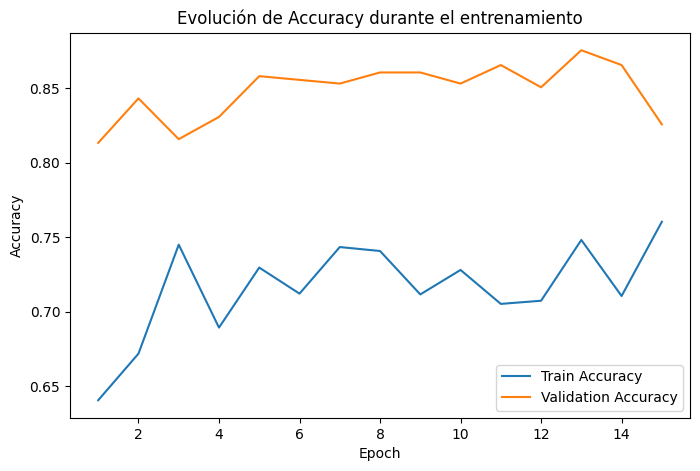

In [52]:
plot_train_results(hist)

In [51]:
# 
acc_after_train, cm_after_train = evaluate_model(model_ft, test_loader, device=device)
print("ResNet50 - Test Accuracy:", acc_after_train)
print("Confusion Matrix:\n", cm_after_train)




/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


ResNet50 - Test Accuracy: 0.8609756097560975
Confusion Matrix:
 [[105  54]
 [  3 248]]
